# Model Evaluation
This material is adapted from the following,
- [Scikit Learn](http://scikit-learn.org/stable/)  
- [Sebastian Raschka](https://github.com/rasbt/python-machine-learning-book)  
- [Jake Vanderplas](https://github.com/jakevdp/sklearn_tutorial)
- [Andreas Mueller](http://amueller.github.io)  
- [Kyle Kastner](https://kastnerkyle.github.io/)  
- [Quantopian Research](https://github.com/quantopian/research_public)
- [Python for Probability, Statistics, and Machine Learning](http://www.springer.com/fr/book/9783319307152), [github](https://github.com/unpingco/Python-for-Probability-Statistics-and-Machine-Learning)

# Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext line_profiler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

# Ignore Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from helper_functions import tic, toc

""" Include Parent Directory in Python Path """
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import pandas as pd

In [2]:
from IPython.display import Image
from sklearn import __version__ as sklearn_version
from distutils.version import LooseVersion as Version

# Cross-Validation
It is good practice to split a dataset into two parts, a training set and a test set. This helps avoid overfitting, while aiding in improved generalization performance (how well it performs on new, unseen data). Use the training set to fit a model and the test set to evaluate its generalization performance.

<img src="http://ml4ef.github.io/images/train_test_split.svg" width=500>

However, often (labeled) data is precious, and this approach lets us only use ~ 3/4 of our data for training. On the other hand, we will only ever try to apply our model 1/4 of our data for testing.
A common way to use more of the data to build a model, but also get a more robust estimate of the generalization performance, is cross-validation.
In cross-validation, the data is split repeatedly into a training and non-overlapping test-sets, with a separate model built for every pair. The test-set scores are then aggregated for a more robust estimate.

The most common way to do cross-validation is k-fold cross-validation, in which the data is first split into k (often 5 or 10) equal-sized folds, and then for each iteration, one of the k folds is used as test data, and the rest as training data. This way, each data point will be in the test-set exactly once, and we can use all but a k'th of the data for training.
Let us apply this technique to evaluate the KNeighborsClassifier algorithm on the Iris dataset:

<img src="http://ml4ef.github.io/images/cross_validation.svg" width=500>

# Parameter selection, Validation, and Testing

Most models have parameters that influence how complex a model they can learn. Recall that we demonstrated the impact of regularization as a means to avoid overfitting in the first class. We also noted that it's favourable to prefer simpler models.

![](../images/plot_kneigbors_regularization.png)
<img src="http://ml4ef.github.io/images/cross_validation.svg" width=500>

In the above figure, we see fits for three different values of ``n_neighbors``.
For ``n_neighbors=2``, the data is overfit, the model is too flexible and can adjust too much to the noise in the training data. For ``n_neighbors=20``, the model is not flexible enough, and can not model the variation in the data appropriately.

In the middle, for ``n_neighbors = 5``, we have found a good mid-point. It fits
the data fairly well, and does not suffer from the overfit or underfit
problems seen in the figures on either side. What we would like is a
way to quantitatively identify overfit and underfit, and optimize the
hyperparameters (in this case, the polynomial degree d) in order to
determine the best algorithm.

We trade off remembering too much about the particularities and noise of the training data vs. not modeling enough of the variability. This is a trade-off that needs to be made in basically every machine learning application and is a central concept, called bias-variance-tradeoff or "overfitting vs underfitting".

![](../images/overfitting_underfitting_cartoon.svg)
<img src="http://ml4ef.github.io/images/cross_validation.svg" width=500>

## Hyperparameters, Over-fitting, and Under-fitting

Unfortunately, there is no general rule how to find the sweet spot, and so machine learning practitioners have to find the best trade-off of model-complexity and generalization by trying several hyperparameter settings. Hyperparameters are the internal knobs or tuning parameters of a machine learning algorithm (in contrast to model parameters that the algorithm learns from the training data -- for example, the weight coefficients of a linear regression model); the number of *k* in K-nearest neighbors is such a hyperparameter.

Most commonly this "hyperparameter tuning" is done using a brute force search, for example over multiple values of ``n_neighbors``:

![](../images/grid_search_cross_validation.svg)
<img src="http://ml4ef.github.io/images/cross_validation.svg" width=500>

Some practitioners go for an easier scheme, splitting the data simply into three parts, training, validation and testing. This is a possible alternative if your training set is very large, or it is infeasible to train many models using cross-validation because training a model takes very long.
You can do this with scikit-learn for example by splitting of a test-set and then applying GridSearchCV with ShuffleSplit cross-validation with a single iteration:

![](../images/train_validation_test2.svg)
<img src="http://ml4ef.github.io/images/cross_validation.svg" width=500>

## Model Validation

An important piece of machine learning is **model validation**: that is, determining how well your model will generalize from the training data to future unlabeled data. Let's look at an example using the *nearest neighbor classifier*. This is a very simple classifier: it simply stores all training data, and for any unknown quantity, simply returns the label of the closest training point.

With the iris data, it very easily returns the correct prediction for each of the input points:

In [3]:
import sklearn.datasets as ds
from sklearn.neighbors import KNeighborsClassifier

iris = ds.load_iris()
X, y = iris.data, iris.target
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)
y_pred = clf.predict(X)
print(np.all(y == y_pred))

True


A more useful way to look at the results is to view the **confusion matrix**, or the matrix showing the frequency of inputs and outputs:

<img src="http://ml4ef.github.io/images/06_08.png" width=500>

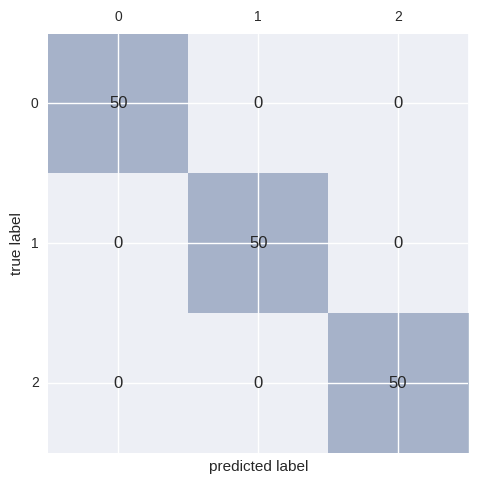

In [49]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()

For each class, all 50 training samples are correctly identified. But this **does not mean that our model is perfect!** In particular, such a model generalizes extremely poorly to new data. We can simulate this by splitting our data into a *training set* and a *testing set*. Scikit-learn contains some convenient routines to do this:

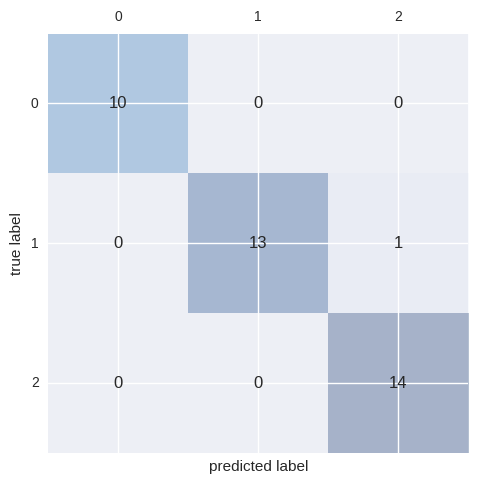

In [50]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

confmat = confusion_matrix(ytest, ypred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()

This paints a better picture of the true performance of our classifier: apparently there is some confusion between the second and third species, which we might anticipate given what we've seen of the data above.

This is why it's **extremely important** to use a train/test split when evaluating your models.  We'll go into more depth on model evaluation later in this tutorial.

# Overfitting, Underfitting and Model Selection
Now that we've gone over the basics of validation, and cross-validation, it's time to go into even more depth regarding model selection.

The issues associated with validation and 
cross-validation are some of the most important
aspects of the practice of machine learning.  Selecting the optimal model
for your data is vital, and is a piece of the problem that is not often
appreciated by machine learning practitioners.

Of core importance is the following question:

**If our estimator is underperforming, how should we move forward?**

- Use simpler or more complicated model?
- Add more features to each observed data point?
- Add more training samples?

The answer is often counter-intuitive.  In particular, **Sometimes using a
more complicated model will give _worse_ results.**  Also, **Sometimes adding
training data will not improve your results.**  The ability to determine
what steps will improve your model is what separates the successful machine
learning practitioners from the unsuccessful.

### Illustration of the Bias-Variance Tradeoff

For this section, we'll work with a simple 1D regression problem.  This will help us to
easily visualize the data and the model, and the results generalize easily to  higher-dimensional
datasets.  We'll explore a simple **linear regression** problem.
This can be accomplished within scikit-learn with the `sklearn.linear_model` module.

We'll create a simple nonlinear function that we'd like to fit

In [2]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

In [3]:
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

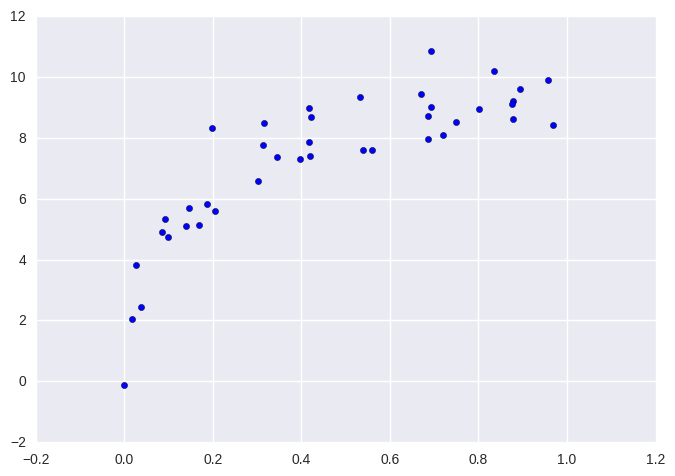

In [6]:
X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);

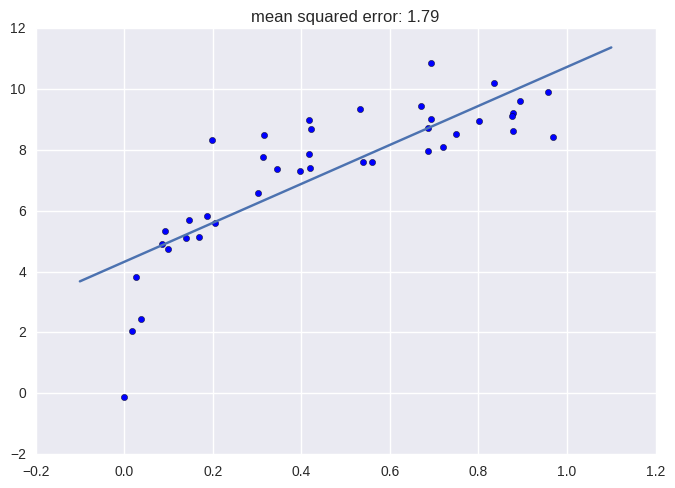

In [7]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

We have fit a straight line to the data, but clearly this model is not a good choice.  We say that this model is **biased**, or that it **under-fits** the data.

Let's try to improve this by creating a more complicated model.  We can do this by adding degrees of freedom, and computing a polynomial regression over the inputs. Scikit-learn makes this easy with the ``PolynomialFeatures`` preprocessor, which can be pipelined with a linear regression.

Let's make a convenience routine to do this:

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Now we'll use this to fit a quadratic curve to the data.

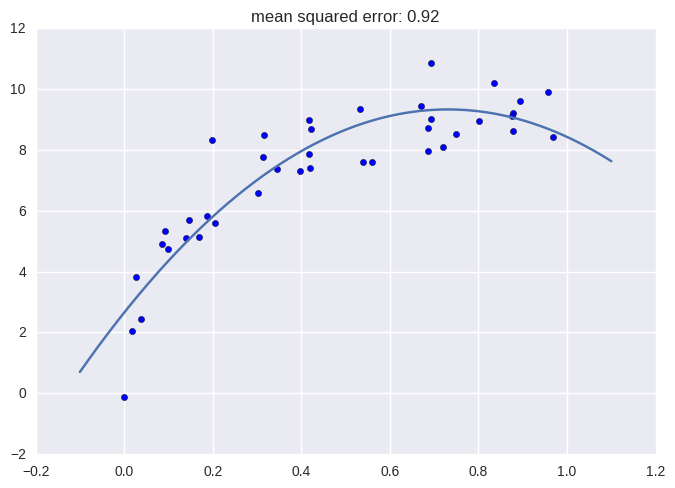

In [9]:
model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

This reduces the mean squared error, and makes a much better fit.  What happens if we use an even higher-degree polynomial?

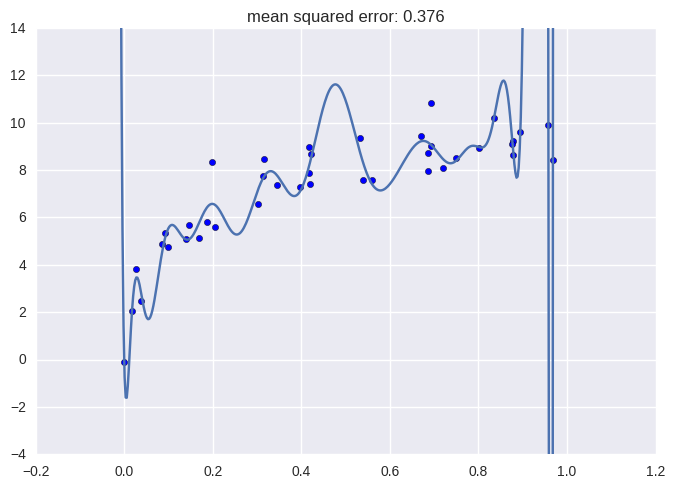

In [10]:
model = PolynomialRegression(30)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.ylim(-4, 14);

When we increase the degree to this extent, it's clear that the resulting fit is no longer reflecting the true underlying distribution, but is more sensitive to the noise in the training data. For this reason, we call it a **high-variance model**, and we say that it **over-fits** the data.

Just for fun, let's use IPython's interact capability (only in IPython 2.0+) to explore this interactively:

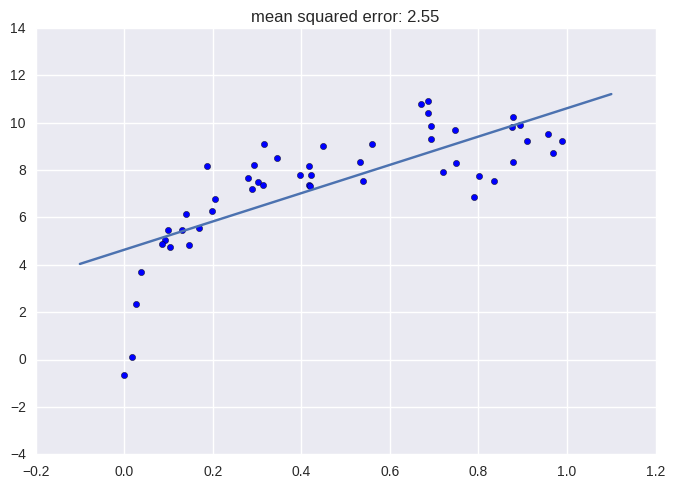

In [12]:
from IPython.html.widgets import interact

def plot_fit(degree=1, Npts=50):
    X, y = make_data(Npts, error=1)
    X_test = np.linspace(-0.1, 1.1, 500)[:, None]
    
    model = PolynomialRegression(degree=degree)
    model.fit(X, y)
    y_test = model.predict(X_test)

    plt.scatter(X.ravel(), y)
    plt.plot(X_test.ravel(), y_test)
    plt.ylim(-4, 14)
    plt.title("mean squared error: {0:.2f}".format(mean_squared_error(model.predict(X), y)))
    
interact(plot_fit, degree=[1, 30], Npts=[2, 100]);

### Detecting Over-fitting with Validation Curves

Clearly, computing the error on the training data is not enough (we saw this previously). As above, we can use **cross-validation** to get a better handle on how the model fit is working. The following figures demonstrate how validation curves can aid in understanding generalization performance.

<img src="http://ml4ef.github.io/images/06_04.png" width=500>

To make things more clear, we'll use the slightly larger dataset visualized in the following figure:

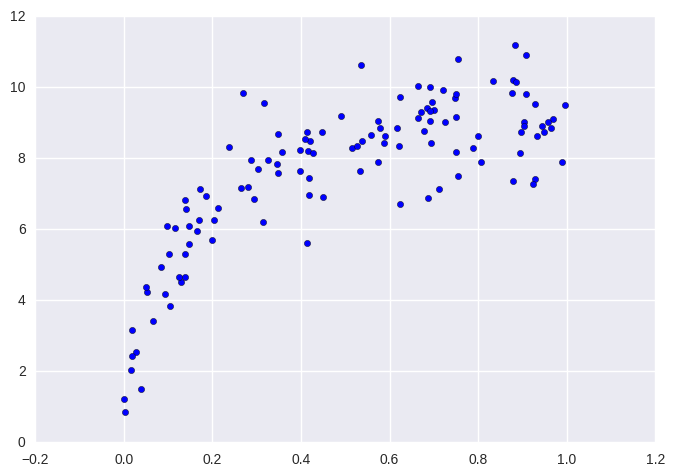

In [13]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);

In [14]:
from sklearn.learning_curve import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

degree = np.arange(0, 18)
val_train, val_test = validation_curve(PolynomialRegression(), X, y,
                                       'polynomialfeatures__degree', degree, cv=7,
                                       scoring=rms_error)

Now let's plot the validation curves:

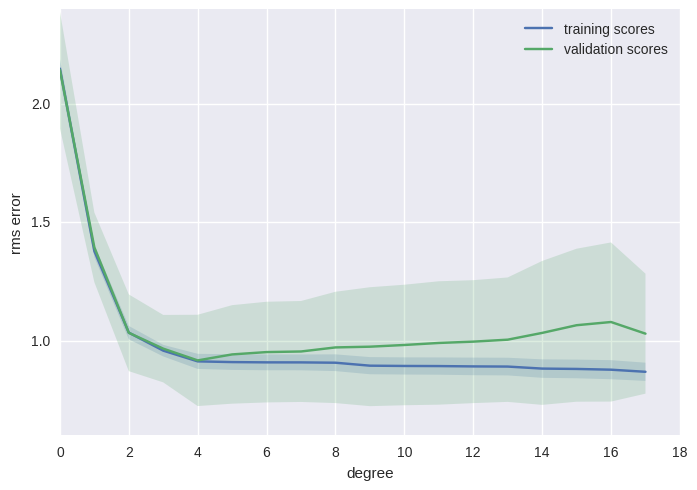

In [16]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend();

Notice the trend here, which is common for this type of plot.

1. For a small model complexity, the training error and validation error are very similar. This indicates that the model is **under-fitting** the data: it doesn't have enough complexity to represent the data. Another way of putting it is that this is a **high-bias** model.

2. As the model complexity grows, the training and validation scores diverge. This indicates that the model is **over-fitting** the data: it has so much flexibility, that it fits the noise rather than the underlying trend. Another way of putting it is that this is a **high-variance** model.

3. Note that the training score (nearly) always improves with model complexity. This is because a more complicated model can fit the noise better, so the model improves. The validation data generally has a sweet spot, which here is around 5 terms.

Here's our best-fit model according to the cross-validation:

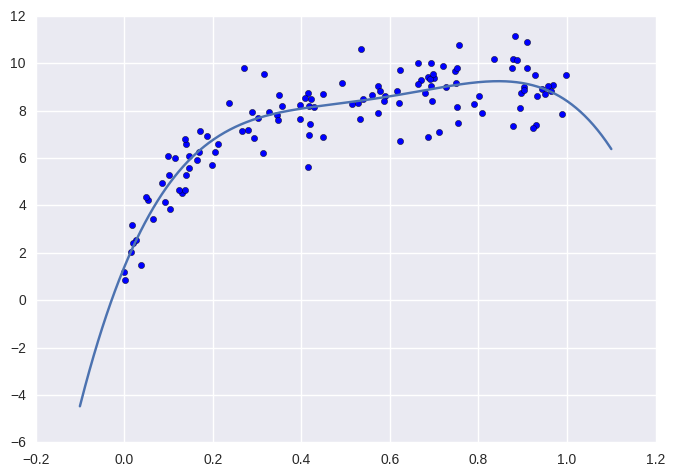

In [17]:
model = PolynomialRegression(4).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test));

### Detecting Data Sufficiency with Learning Curves

As you might guess, the exact turning-point of the tradeoff between bias and variance is highly dependent on the number of training points used.  Here we'll illustrate the use of *learning curves*, which display this property.

The idea is to plot the mean-squared-error for the training and test set as a function of *Number of Training Points*

In [19]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(degree=3):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(PolynomialRegression(degree),
                                                  X, y, train_sizes, cv=5,
                                                  scoring=rms_error)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('rms error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()

Let's see what the learning curves look like for a linear model:

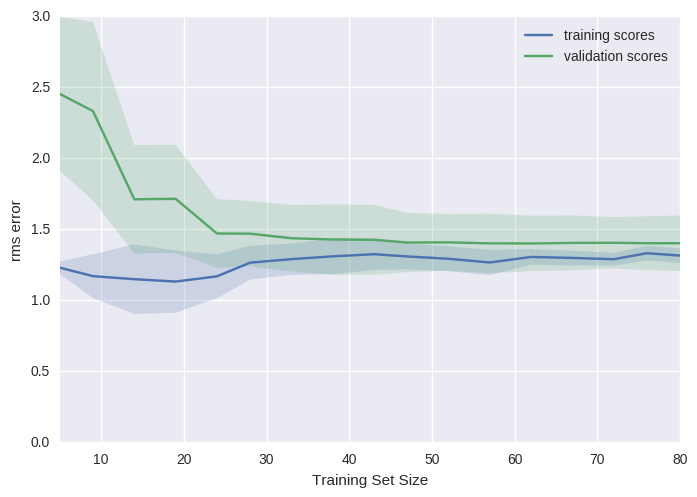

In [22]:
plot_learning_curve(1)

This shows a typical learning curve: for very few training points, there is a large separation between the training and test error, which indicates **over-fitting**.  Given the same model, for a large number of training points, the training and testing errors converge, which indicates potential **under-fitting**.

As you add more data points, the training error will never increase, and the testing error will never decrease (why do you think this is?)

It is easy to see that, in this plot, if you'd like to reduce the MSE down to the nominal value of 1.0 (which is the magnitude of the scatter we put in when constructing the data), then adding more samples will *never* get you there.  For $d=1$, the two curves have converged and cannot move lower. What about for a larger value of $d$?

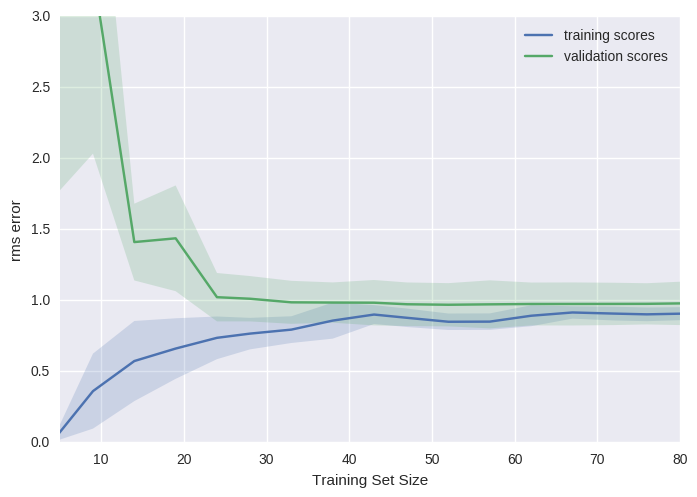

In [24]:
plot_learning_curve(3)

Here we see that by adding more model complexity, we've managed to lower the level of convergence to an rms error of 1.0!

What if we get even more complex?

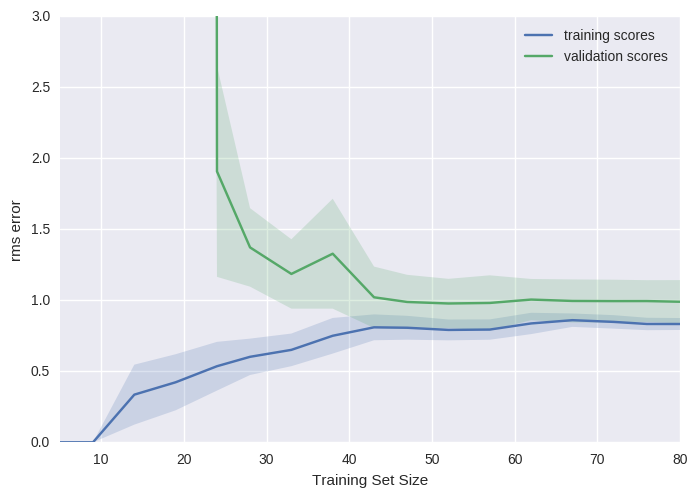

In [25]:
plot_learning_curve(10)

For an even more complex model, we still converge, but the convergence only happens for *large* amounts of training data.

So we see the following:

- you can **cause the lines to converge** by adding more points or by simplifying the model.
- you can **bring the convergence error down** only by increasing the complexity of the model.

Thus these curves can give you hints about how you might improve a sub-optimal model. If the curves are already close together, you need more model complexity. If the curves are far apart, you might also improve the model by adding more data.

To make this more concrete, imagine some telescope data in which the results are not robust enough.  You must think about whether to spend your valuable telescope time observing *more objects* to get a larger training set, or *more attributes of each object* in order to improve the model.  The answer to this question has real consequences, and can be addressed using these metrics.

# The holdout method

<img src="http://ml4ef.github.io/images/06_02.png" width=500>

## Get Data

In [52]:
import numpy as np

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import StratifiedKFold
else:
    from sklearn.model_selection import StratifiedKFold

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
             '/breast-cancer-wisconsin/wdbc.data', header=None)

from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

## Combining transformers and estimators in a pipeline

<img src="http://ml4ef.github.io/images/06_01.png" width=500>

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])

pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))
y_pred = pipe_lr.predict(X_test)

Test Accuracy: 0.947


## K-fold cross-validation

<img src="http://ml4ef.github.io/images/06_03.png" width=500>

In [56]:
if Version(sklearn_version) < '0.18':
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=10,
                            random_state=1)
else:
    kfold = StratifiedKFold(n_splits=10,
                            random_state=1).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.029


## We can also use the built-in CV function

In [57]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import cross_val_score
else:
    from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


## Optimizing the precision and recall of a classification model

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.974
Recall: 0.881
F1: 0.925


In [61]:
from sklearn.svm import SVC

from sklearn.metrics import make_scorer
if Version(sklearn_version) < '0.18':
    from sklearn.grid_search import GridSearchCV
else:
    from sklearn.model_selection import GridSearchCV
    
pipe_svc = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=1))])

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'clf__C': c_gamma_range,
               'clf__kernel': ['linear']},
              {'clf__C': c_gamma_range,
               'clf__gamma': c_gamma_range,
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.982798668208
{'clf__kernel': 'linear', 'clf__C': 0.1}


In [62]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


## Algorithm selection with nested cross-validation

<img src="http://ml4ef.github.io/images/06_07.png" width=500>

In [64]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

# Note: Optionally, you could use cv=2 
# in the GridSearchCV above to produce
# the 5 x 2 nested CV that is shown in the figure.

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.960 +/- 0.026


In [65]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.921 +/- 0.029


## Plotting a receiver operating characteristic

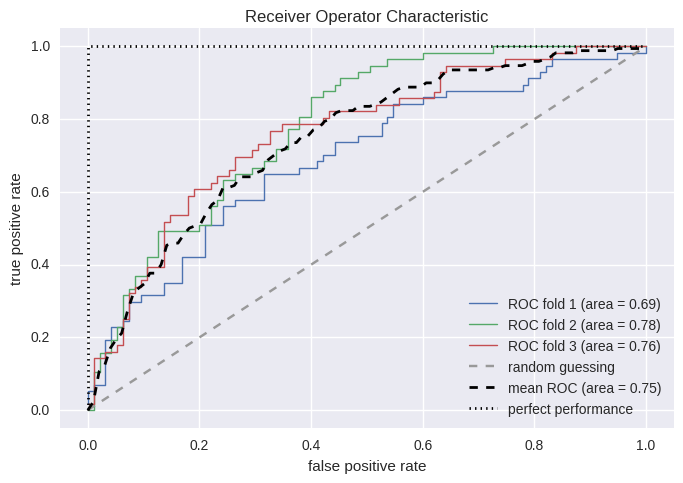

In [66]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])

X_train2 = X_train[:, [4, 14]]


if Version(sklearn_version) < '0.18':
    cv = StratifiedKFold(y_train, 
                         n_folds=3, 
                         random_state=1)
    
else:
    cv = list(StratifiedKFold(n_splits=3, 
                              random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

In [67]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])

In [68]:
from sklearn.metrics import roc_auc_score, accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.662
Accuracy: 0.711


## Summary

We've gone over several useful tools for model validation

- The **Training Score** shows how well a model fits the data it was trained on. This is not a good indication of model effectiveness
- The **Validation Score** shows how well a model fits hold-out data. The most effective method is some form of cross-validation, where multiple hold-out sets are used.
- **Validation Curves** are a plot of validation score and training score as a function of **model complexity**:
  + when the two curves are close, it indicates *underfitting*
  + when the two curves are separated, it indicates *overfitting*
  + the "sweet spot" is in the middle
- **Learning Curves** are a plot of the validation score and training score as a function of **Number of training samples**
  + when the curves are close, it indicates *underfitting*, and adding more data will not generally improve the estimator.
  + when the curves are far apart, it indicates *overfitting*, and adding more data may increase the effectiveness of the model.
  
These tools are powerful means of evaluating your model on your data.